# Exploratory Data Analysis: Grantnav Dataset (Downloaded 20/04/2021)

**Research Question**
    
Is it possible to predict grant value from description keywords, location-based data and/or other characteristics?

## 0.0 Libraries

In [1]:
%load_ext autoreload
%autoreload 2

#system
import os
import sys
from os.path import join as pj
module_path = os.path.abspath(pj('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# data
import pandas as pd
import numpy as np

# viz
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('bmh')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import missingno as msno

# configurations
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import configparser

#stats
import scipy

# utils
from src.d00_utils import print_helper_functions as phf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.1 Configurations and Directories

In [2]:
# not used in this stub but often useful for finding various files
project_dir = Path().resolve().parents[1]
print(project_dir)

# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
_ = load_dotenv(find_dotenv())

raw_dir = pj(project_dir, 'data', os.environ.get('RAW_DIR'))
interim_dir = pj(project_dir, 'data', os.environ.get('INTERIM_DIR'))
processed_dir = pj(project_dir, 'data', os.environ.get('PROCESSED_DIR'))

/Users/marclawson/repositories/grantnav_10k_predictor


## 1.0 Load Data

In [3]:
data = pd.read_csv(pj(interim_dir,'grantnav_data.csv'), index_col=0)

## 1.1 Size and shape

In [4]:
data.head()
data.shape

,identifier,currency,title,description,amount_awarded,award_date,recipient_org_identifier,recipient_org_name,funding_org_identifier,funding_org_name,planned_dates_duration_months
0,360G-SE-2011020480EXCH_2012-04-16,GBP,Active Men Project,Funding under Sport England's Sportsmatch fund...,41100.0,2012-04-16,GB-COH-07626625,Positive Futures North Liverpool Ltd,GB-COH-RC000766,Sport England,11.0
1,360G-SE-2012000041EXCH_2012-04-16,GBP,Sporting Futures Leadership Academy,Funding under Sport England's Sportsmatch fund...,6000.0,2012-04-16,GB-CHC-1041422,Sporting Futures,GB-COH-RC000766,Sport England,11.0
2,360G-SE-2012000173EXCH_2012-04-16,GBP,Choices,Funding under Sport England's Sportsmatch fund...,36750.0,2012-04-16,GB-COH-01696490,Greenbank Project,GB-COH-RC000766,Sport England,11.0
3,360G-SE-2012000554EXCH_2012-04-16,GBP,Florrie Sports,Funding under Sport England's Sportsmatch fund...,15000.0,2012-04-16,GB-COH-05330850,The Florence Institute Trust Ltd,GB-COH-RC000766,Sport England,11.0
4,360G-SE-2010011194LOTT_2012-04-17,GBP,Engaging children and adults in Kwic Cricket s...,Funding under Sport England's Small Grants fun...,692.0,2012-04-17,360G-SE-Barmston Village Primary School,Barmston Village Primary School,GB-COH-RC000766,Sport England,3.0


(525023, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525023 entries, 0 to 561423
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   identifier                     525023 non-null  object 
 1   currency                       525023 non-null  object 
 2   title                          525023 non-null  object 
 3   description                    525023 non-null  object 
 4   amount_awarded                 525023 non-null  float64
 5   award_date                     525023 non-null  object 
 6   recipient_org_identifier       525023 non-null  object 
 7   recipient_org_name             525020 non-null  object 
 8   funding_org_identifier         525023 non-null  object 
 9   funding_org_name               525023 non-null  object 
 10  planned_dates_duration_months  525023 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


## 1.2 Grant Value Statistics (Handling Outliers)

In [6]:
grant_value = data['amount_awarded']
phf.print_full(grant_value.describe())

count             525,023.00
mean               39,985.73
std                78,117.54
min                   300.00
25%                 4,000.00
50%                 9,700.00
75%                30,000.00
max             1,381,438.97
Name: amount_awarded, dtype: float64

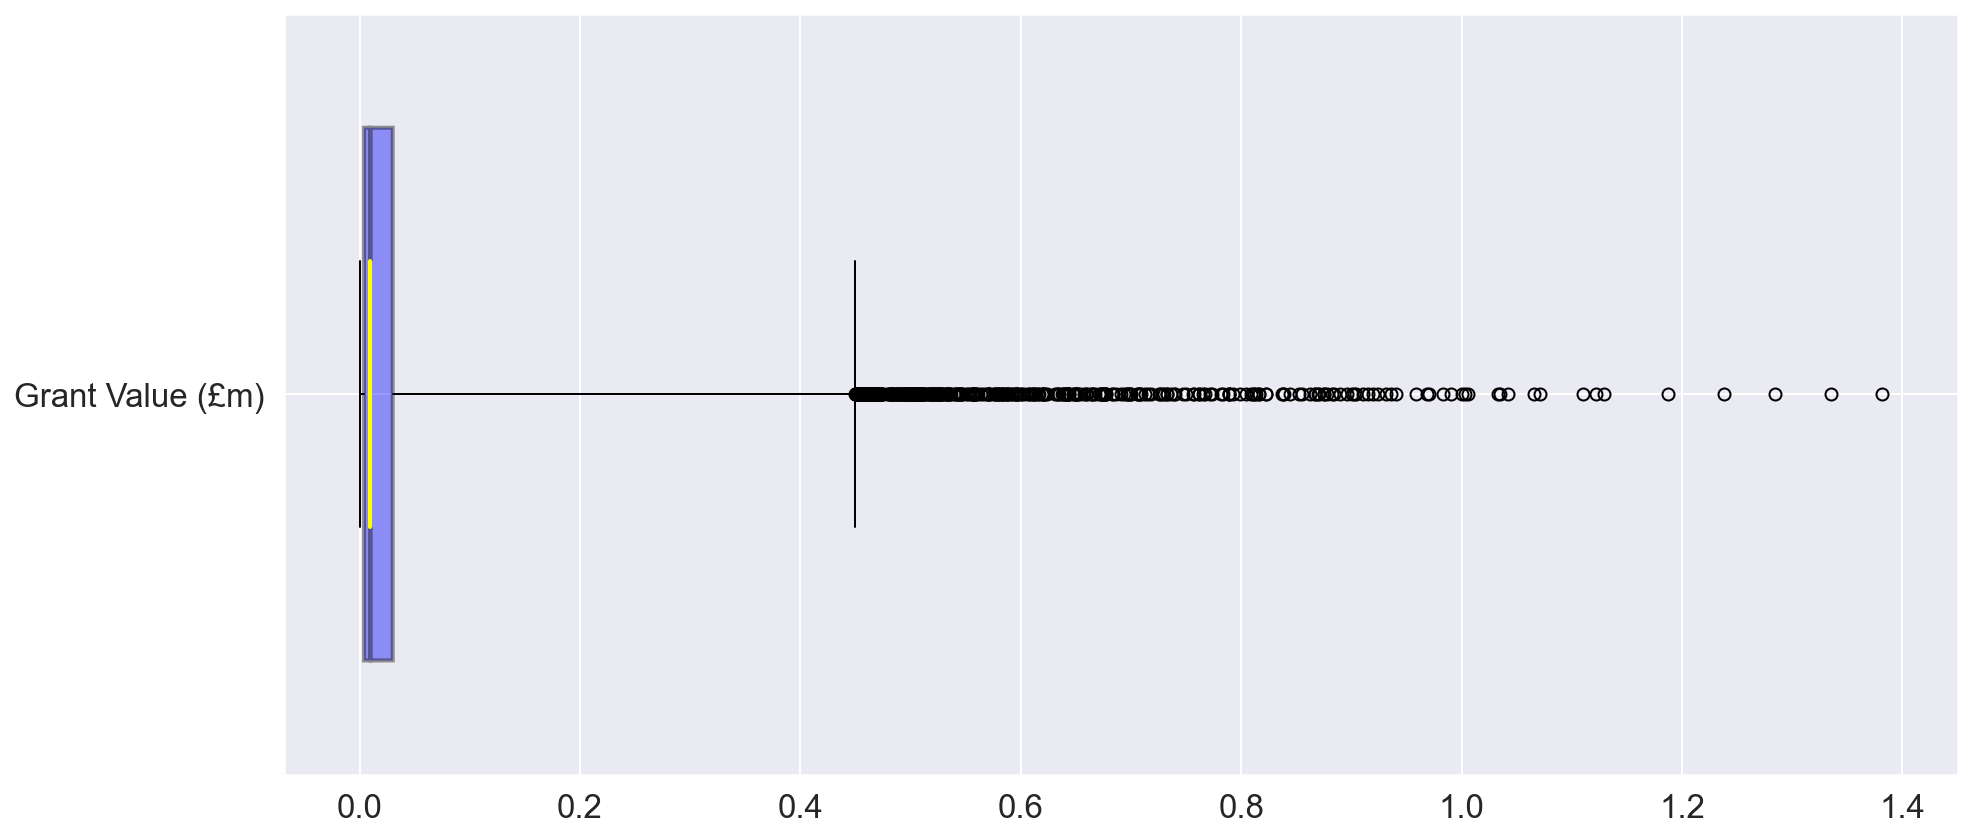

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
kwargs = {
    'vert': False,
    'whis': [0.3,99.7],
    'notch': True,
    'labels': [f'Grant Value (\u00A3m)'],
    'widths': .7,
    'patch_artist': True,
    'medianprops': dict(linestyle='-', linewidth=2, color='Yellow'),
    'boxprops': dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
}
ax.boxplot(grant_value/1000000, **kwargs)
plt.show();

## 1.3 Handling Categorical Data

In [8]:
data.columns

Index(['identifier', 'currency', 'title', 'description', 'amount_awarded',
       'award_date', 'recipient_org_identifier', 'recipient_org_name',
       'funding_org_identifier', 'funding_org_name',
       'planned_dates_duration_months'],
      dtype='object')

### 1.3.1 Funders

In [9]:
funders = pd.get_dummies(data['funding_org_name'])

In [10]:
data_with_funders = pd.concat([data, funders], axis=1)
columns = [c for c in data_with_funders.columns if not c.startswith('funding')]

In [11]:
data_with_funders = data_with_funders.iloc[:,11:]
data_with_funders['amount_awarded'] = data['amount_awarded']
#data_with_funders = data_with_funders[data_with_funders['amount_awarded']<=10000]

In [12]:
funders_corr = data_with_funders.corr()

In [13]:
phf.print_full(funders_corr.loc['amount_awarded',:].T.sort_values(ascending=False).head(10))

amount_awarded                                                            1.00
Department for Business, Energy and Industrial Strategy                   0.31
The Wellcome Trust                                                        0.15
Department for Education                                                  0.11
Home Office                                                               0.11
Department for International Development                                  0.08
Ministry for Housing, Communities and Local Government                    0.06
Esmée Fairbairn Foundation                                                0.06
Comic Relief                                                              0.05
Ministry of Housing, Communities & Local Government                       0.05
Name: amount_awarded, dtype: float64

There is not much of a correlation between funders and award amount.  A lot of the funding comes from The National Lottery Community Fund and everything after that has little impact on the award amount.

### 1.3.2 Recipients

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
recipients_cat_1hot = cat_encoder.fit_transform(data[['recipient_org_name']])

In [15]:
recipients_cat_1hot.shape

(525023, 222122)

This is a large matrix and it seems there would be little gain from knowing correlations of recipients and amount awarded.

## 1.4 Time Series (Award Date)

The remaining variables to investigate are the award dates and description word vectors.  I will investigate the time series first.

In [16]:
awards_by_date = data.groupby('award_date')['amount_awarded'].mean().reset_index()
awards_by_date['award_date'] = pd.to_datetime(awards_by_date['award_date'])
awards_by_date = awards_by_date.set_index('award_date',drop=True)

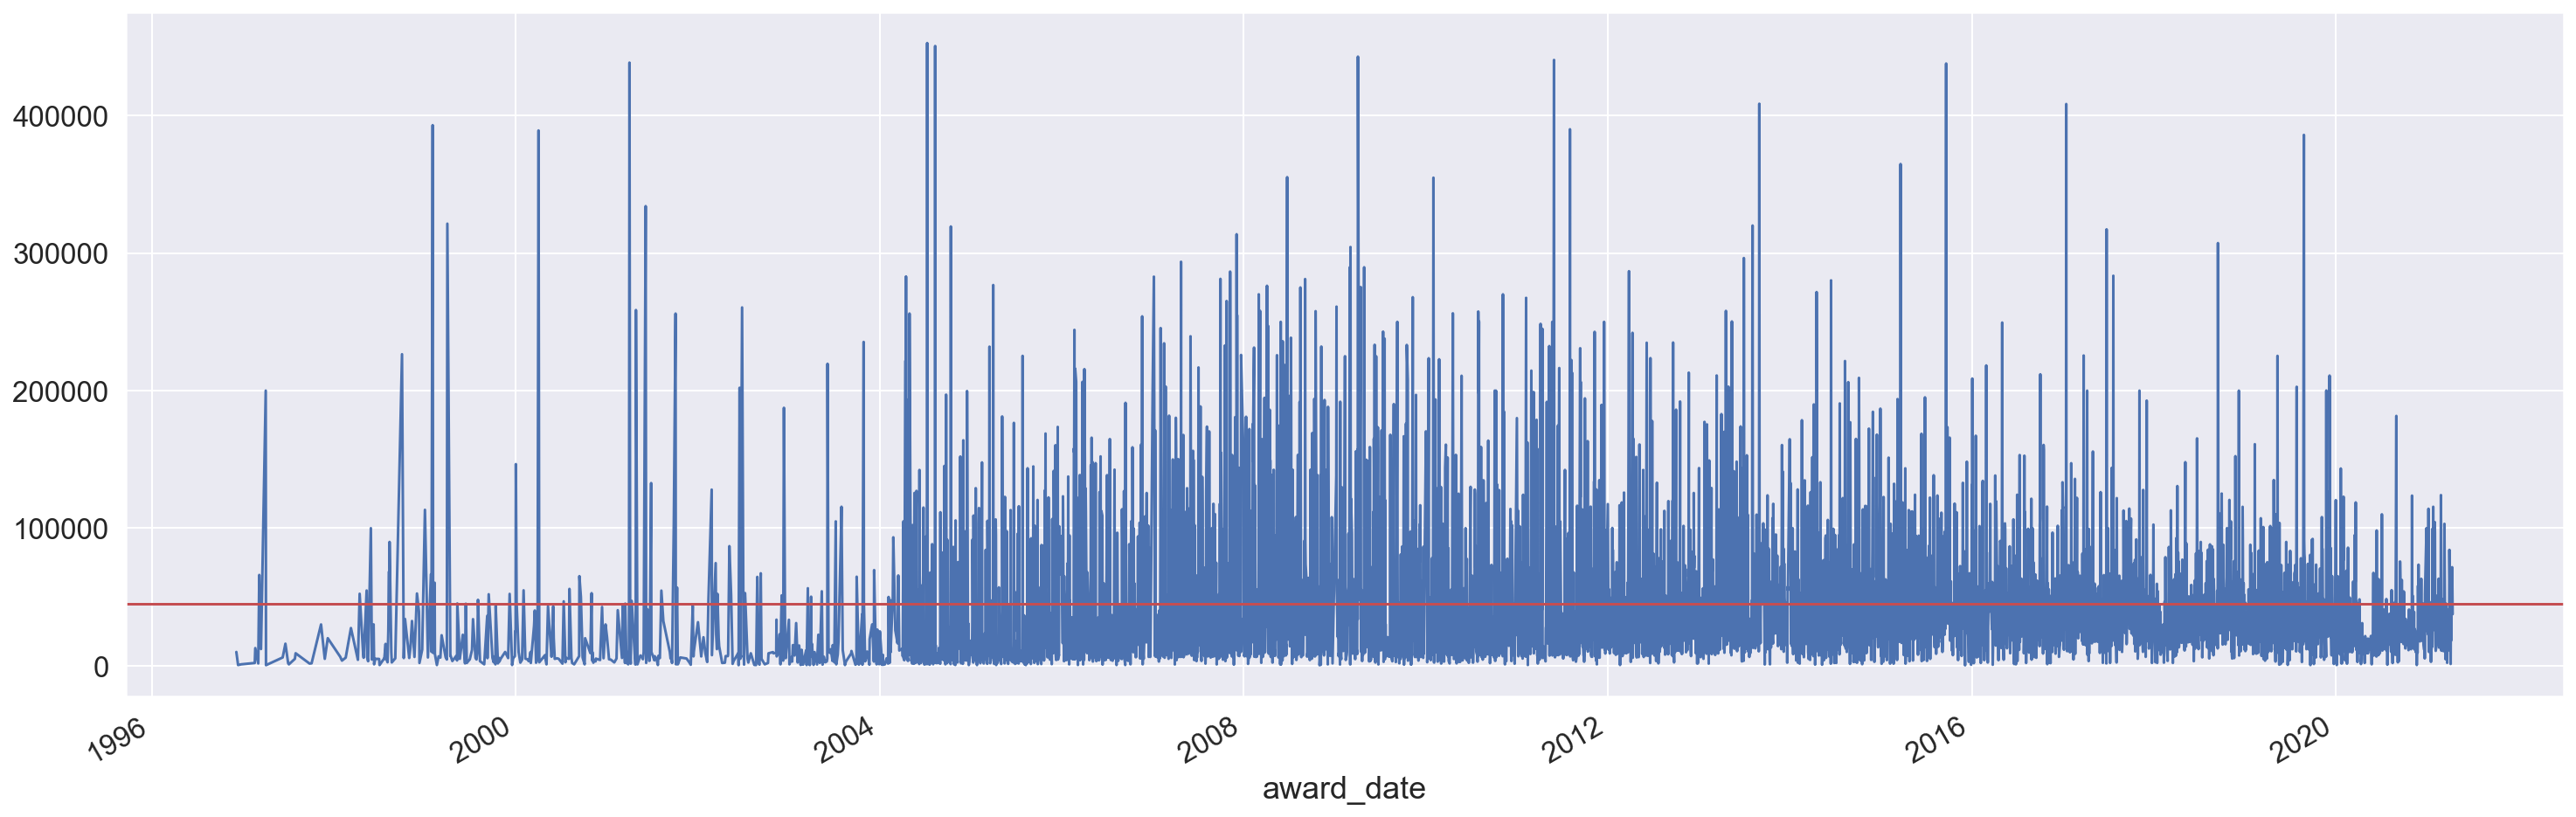

In [56]:
awards_by_date['amount_awarded'].plot(figsize=(25,8))
plt.axhline(awards_by_date['amount_awarded'].mean(), color='r')
plt.show();

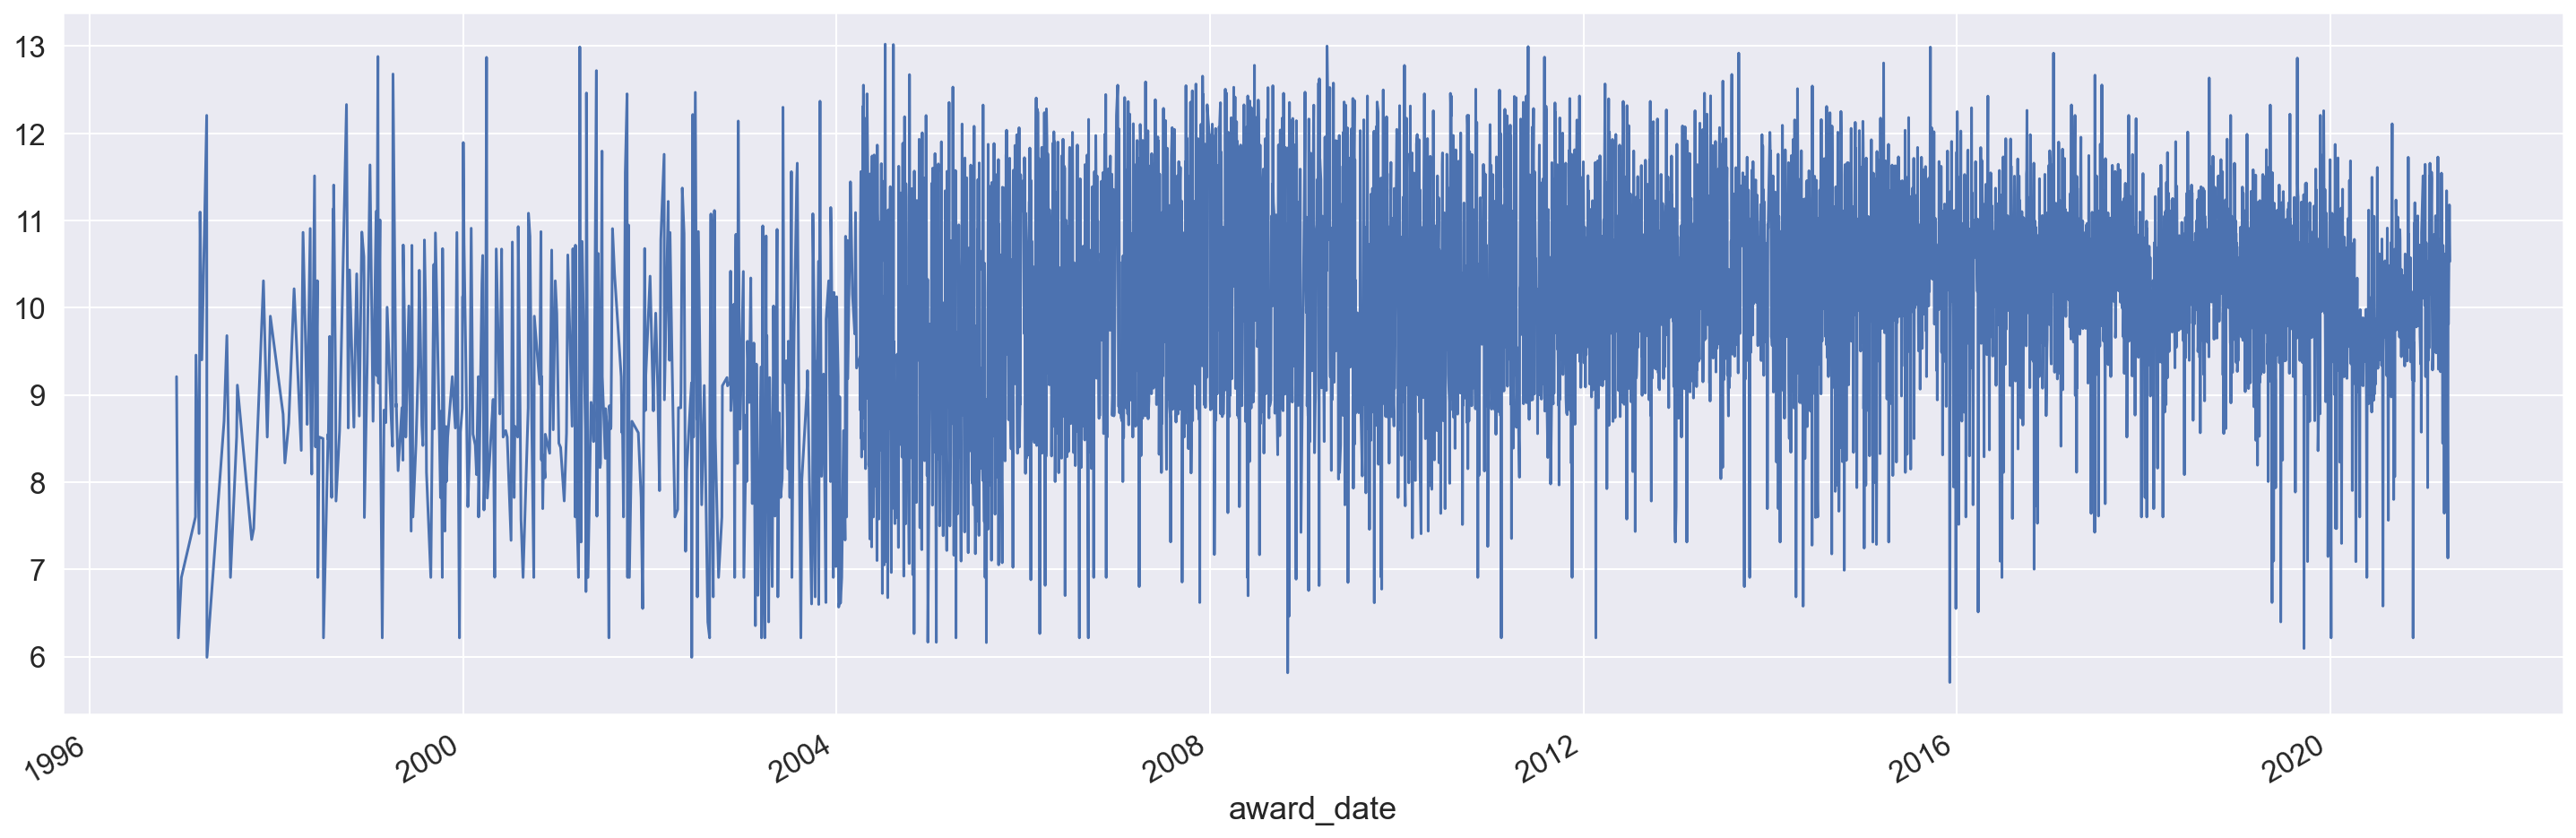

In [19]:
np.log(awards_by_date['amount_awarded']).plot(figsize=(25,8));

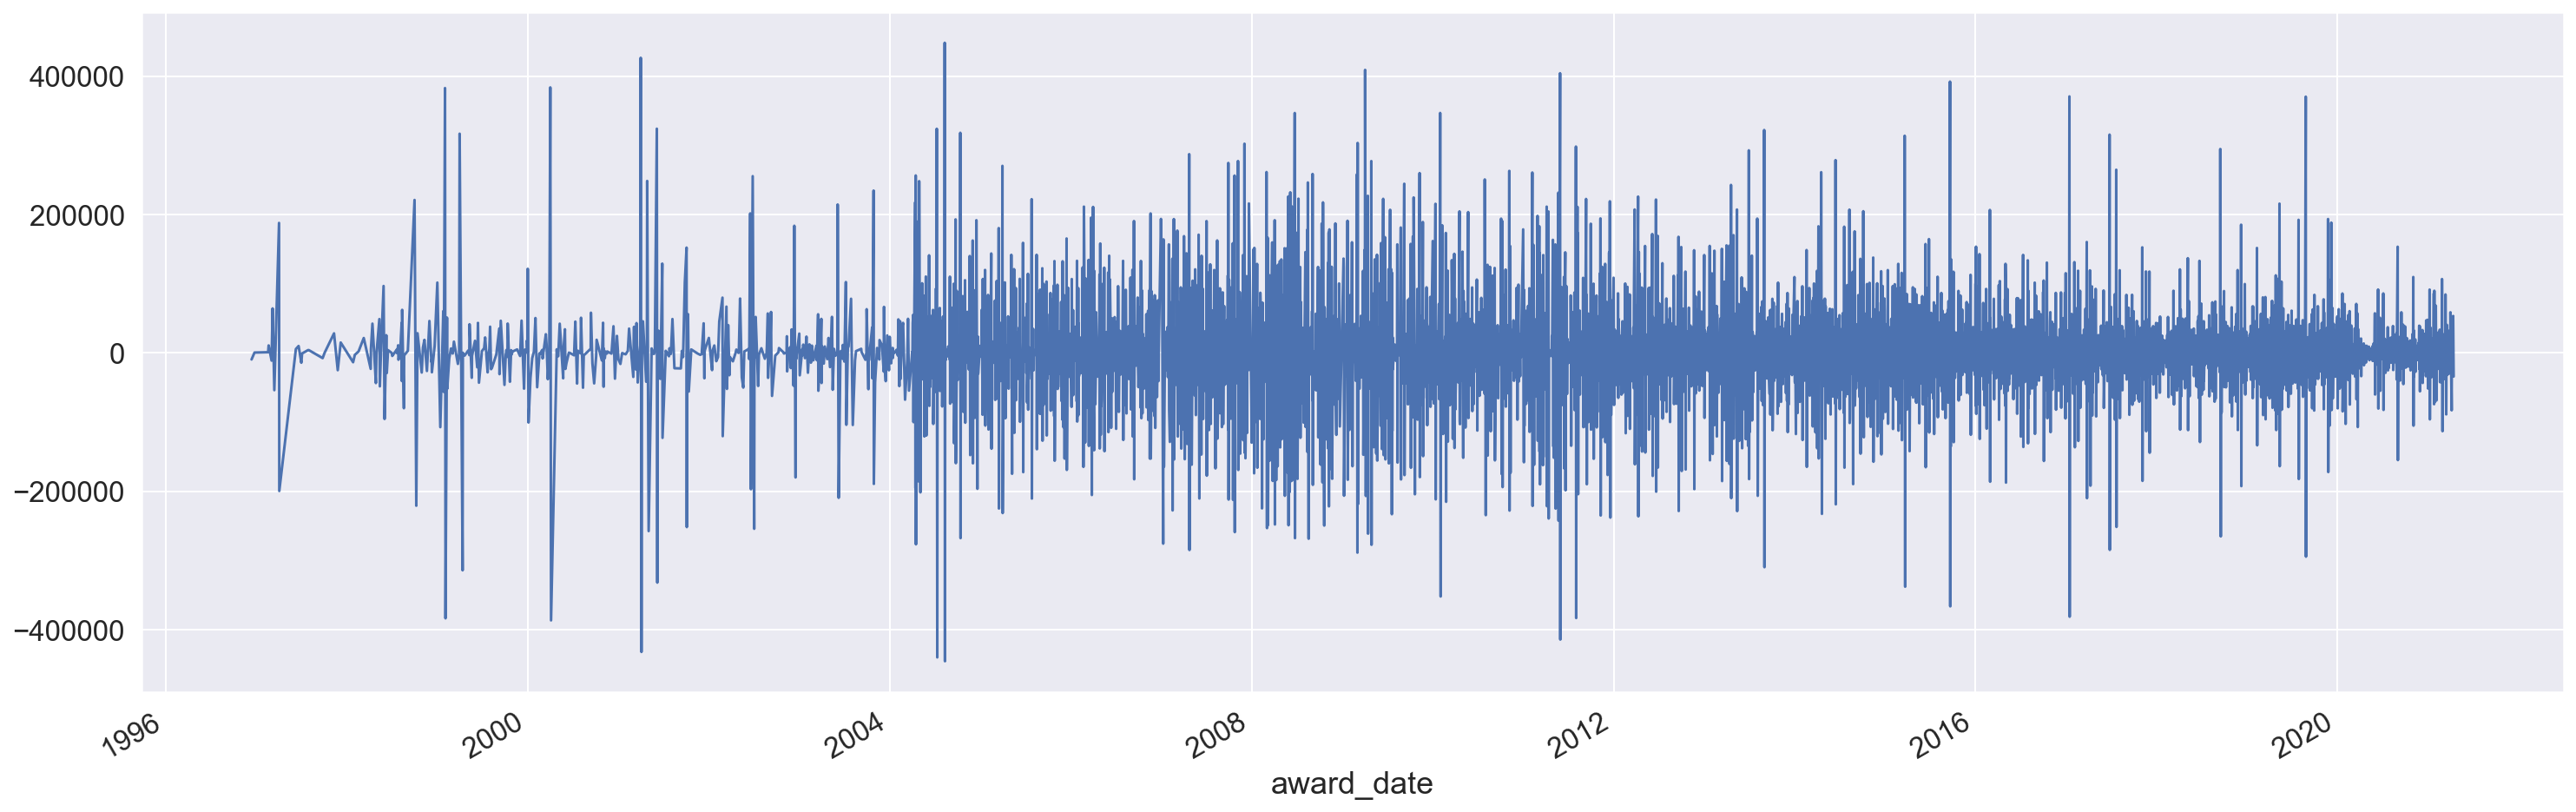

In [21]:
awards_by_date['amount_awarded'].diff().plot(figsize=(25,8));

Resample to weekly and monthly means

In [87]:
awards_by_date['amount_awarded'].head()

award_date
1996-12-05    10000.00
1996-12-12      500.00
1996-12-24     1000.00
1997-02-17     2000.00
1997-02-19    12801.81
Name: amount_awarded, dtype: float64

In [107]:
awards_by_month = pd.DataFrame(awards_by_date['amount_awarded'].resample('M').median().fillna(0),columns=['amount_awarded'])
awards_by_month

,amount_awarded
award_date,
1996-12-31,1000.000000
1997-01-31,0.000000
1997-02-28,7400.905000
1997-03-31,12121.000000
1997-04-30,100200.000000
...,...
2020-12-31,28534.902129
2021-01-31,29981.407527
2021-02-28,27876.400000


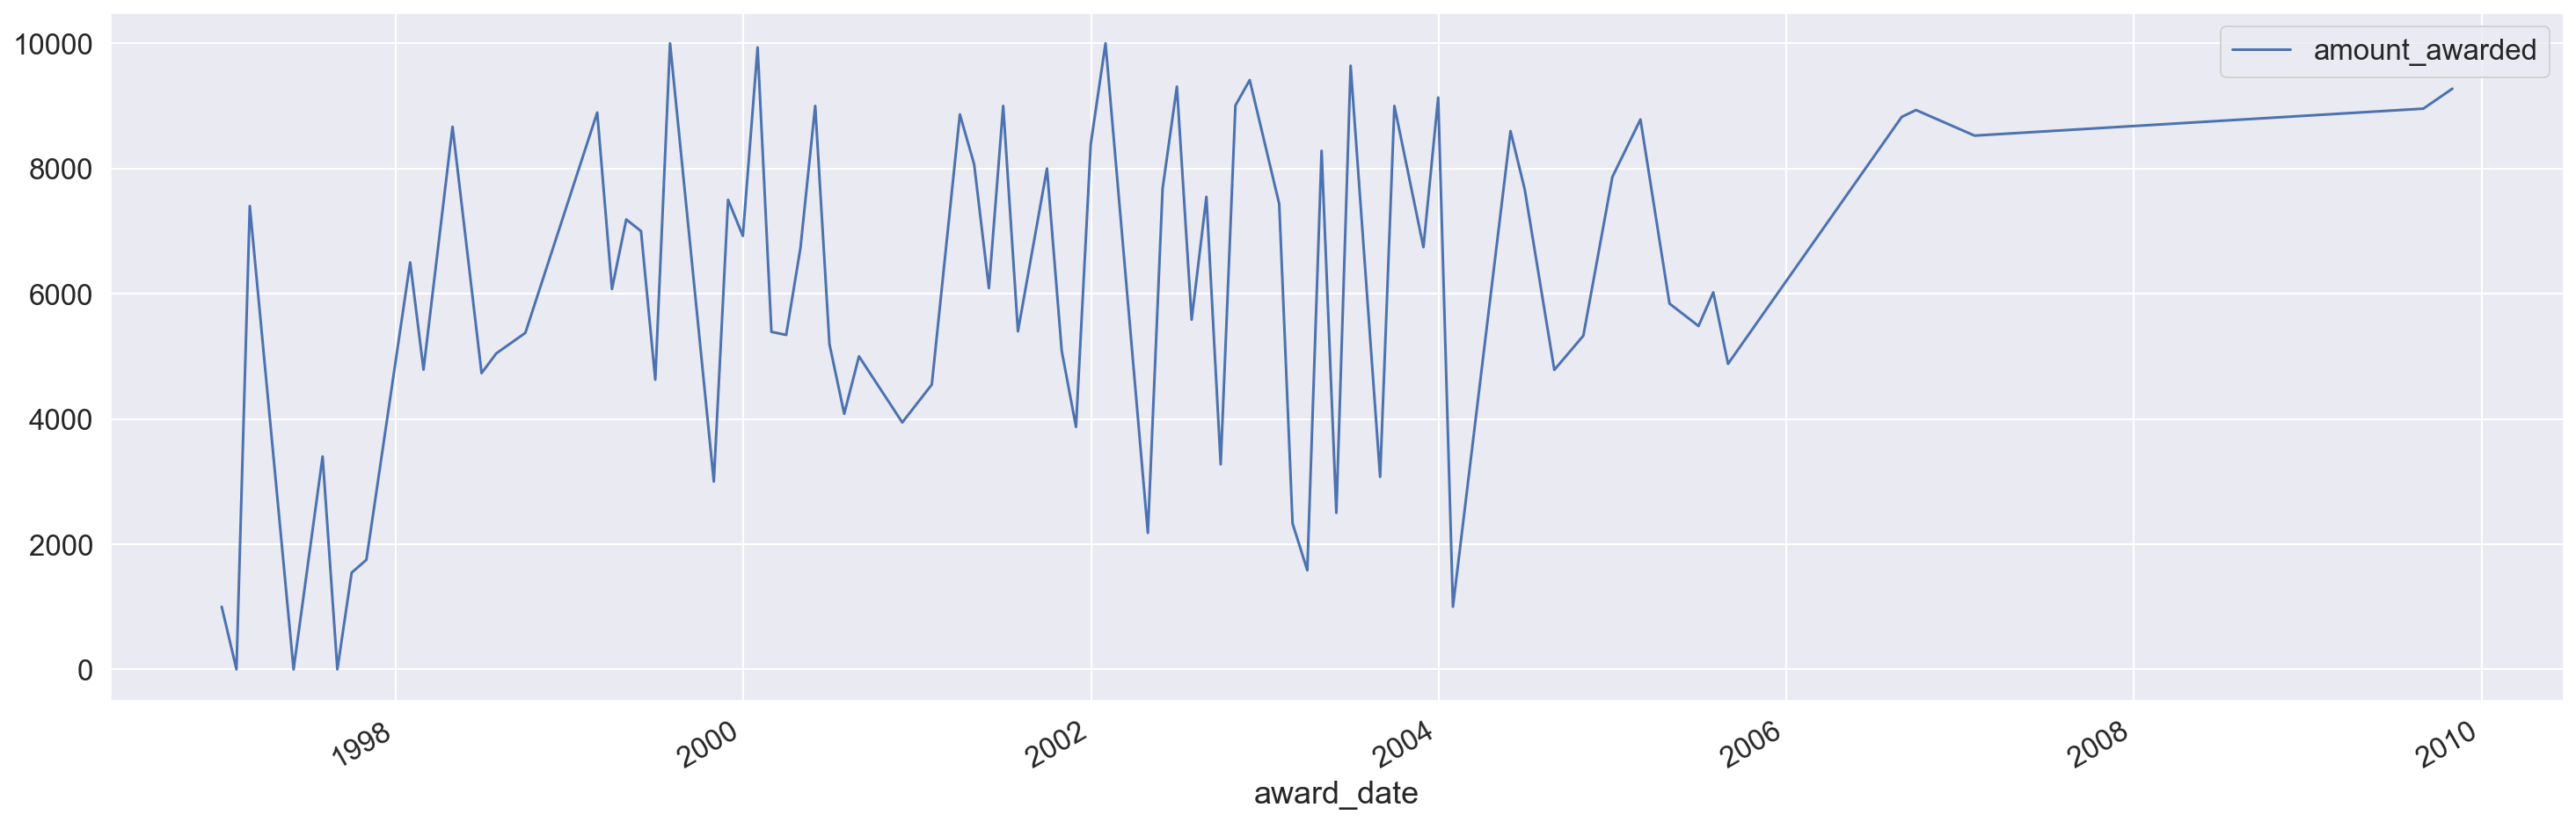

In [108]:
awards_by_month[awards_by_month['amount_awarded']<=10000].plot(figsize=(25,8));

<AxesSubplot:xlabel='award_date'>

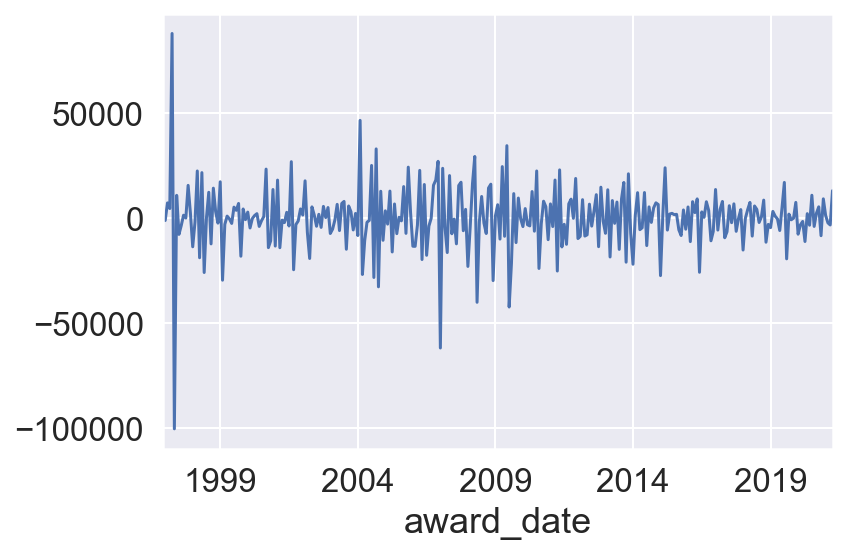

In [101]:
awards_by_month.diff().plot()

### 1.4.1 Ordinary Regression

In [99]:
awards_by_date['lag1'] = awards_by_date['amount_awarded'].shift(1)
shifted_1 = awards_by_date['lag1']

In [73]:
from sklearn.metrics import mean_squared_error
print(f"{mean_squared_error(awards_by_date['amount_awarded'].iloc[1:], shifted_1[1:]):,.0f}")

5,447,498,123


In [74]:
awards_by_date['amount_awarded'].iloc[1:]
shifted_1[1:]

award_date
1996-12-12      500.000000
1996-12-24     1000.000000
1997-02-17     2000.000000
1997-02-19    12801.810000
1997-03-03     1654.055686
                  ...     
2021-04-06     1250.000000
2021-04-07    38497.186441
2021-04-08    18246.000000
2021-04-12    71634.000000
2021-04-14    37484.135135
Name: amount_awarded, Length: 5271, dtype: float64

award_date
1996-12-12    10000.000000
1996-12-24      500.000000
1997-02-17     1000.000000
1997-02-19     2000.000000
1997-03-03    12801.810000
                  ...     
2021-04-06    84248.871331
2021-04-07     1250.000000
2021-04-08    38497.186441
2021-04-12    18246.000000
2021-04-14    71634.000000
Name: lag1, Length: 5271, dtype: float64

In [77]:
X = awards_by_date.reset_index().index
y = awards_by_date.amount_awarded

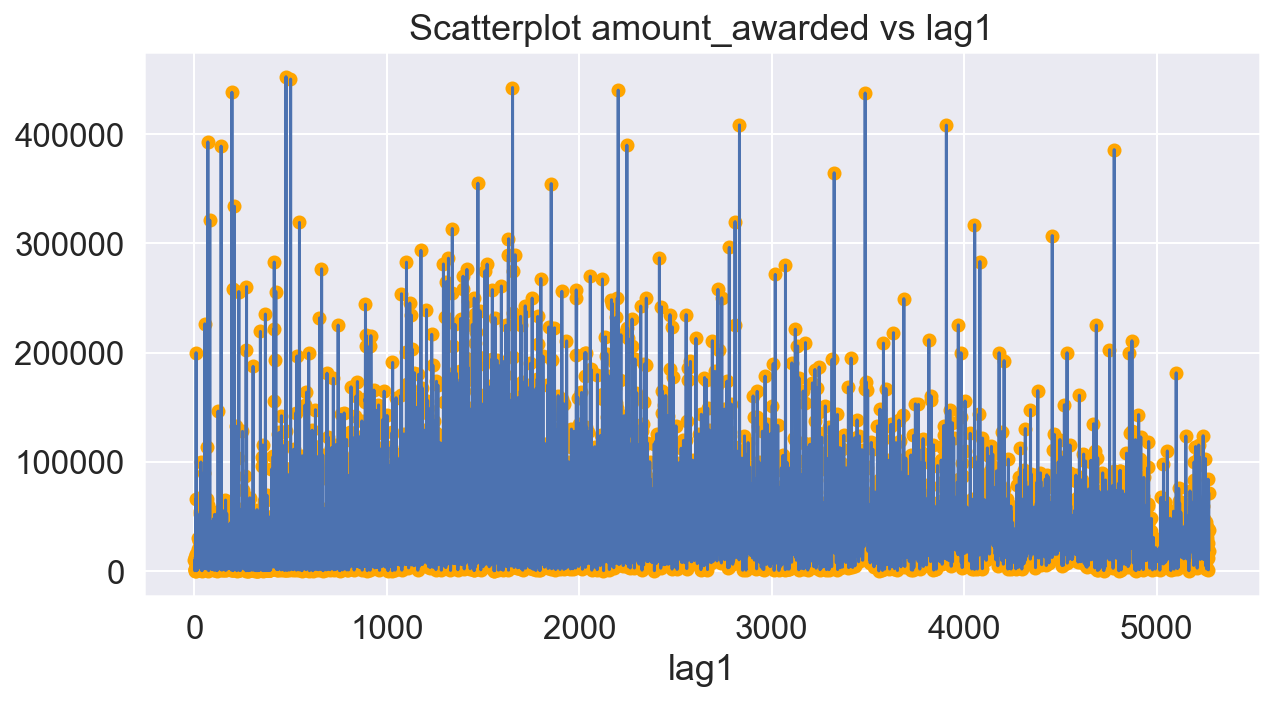

In [84]:
pred_values = awards_by_date['lag1']
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x=X, y=y, color='orange')
ax.plot(X, pred_values)
ax.set_title('Scatterplot amount_awarded vs lag1')
ax.set_xlabel('lag1')
plt.show();

In [25]:
[(i, 
  mean_squared_error(awards_by_date['amount_awarded'].iloc[i:], 
                     awards_by_date['amount_awarded'].shift(i).iloc[i:]))
  for i in range(1, 30)]

[(1, 5447498123.497777),
 (2, 5530597723.4969845),
 (3, 5655110968.693043),
 (4, 5651248695.031106),
 (5, 5521812595.349659),
 (6, 5609612391.473475),
 (7, 5713894665.555237),
 (8, 5626603110.54496),
 (9, 5741877633.082153),
 (10, 5543092454.621012),
 (11, 5511111612.134372),
 (12, 5641867907.155433),
 (13, 5464170796.520659),
 (14, 5376800682.243927),
 (15, 5732185953.920433),
 (16, 5417939658.54622),
 (17, 5565092930.774841),
 (18, 5568734682.307431),
 (19, 5546439148.501663),
 (20, 5392589479.906235),
 (21, 5538786926.348315),
 (22, 5405607771.918506),
 (23, 5456354143.971093),
 (24, 5274511222.274525),
 (25, 5690729855.682922),
 (26, 5544594497.020551),
 (27, 5494795949.970309),
 (28, 5706424617.036758),
 (29, 5431324490.239066)]

In [26]:
awards_by_date['award_shift24'] = awards_by_date['amount_awarded'].shift(24)

In [27]:
X = awards_by_date[['amount_awarded','award_shift24']].copy()
X.dropna(inplace=True)

In [28]:
X.corr()

,amount_awarded,award_shift24
amount_awarded,1.000000,0.084145
award_shift24,0.084145,1.000000


In [32]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tqdm import tqdm
from scipy import stats

In [52]:
def autocorr_plots(y, lags=20, alpha=0.05, figsize=(12,4)):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=figsize, sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'Autocorrelation at {lags} lag/s')

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'Partial Autocorrelation at {lags} lag/s')

    return fig, ax

In [34]:
def pandas_autocorr(y, lag=1):
    X = pd.DataFrame({'a': y, 'b': y.shift(lag)}).copy()
    X.dropna(inplace=True)
    autocorr = X.corr().iloc[0, 1]
    return X

In [38]:
awards_by_date

,amount_awarded,award_shift6,award_shift24
award_date,,,
1996-12-05,10000.000000,NaN,NaN
1996-12-12,500.000000,NaN,NaN
1996-12-24,1000.000000,NaN,NaN
1997-02-17,2000.000000,NaN,NaN
1997-02-19,12801.810000,NaN,NaN
...,...,...,...
2021-04-06,1250.000000,10810.312500,14330.733636
2021-04-07,38497.186441,30713.583333,41143.712698
2021-04-08,18246.000000,23957.838594,32021.211009


In [53]:
concat_list = []
for i in [1,2,24,52]:
    s = pandas_autocorr(awards_by_date['amount_awarded'], lag=i)
    s.columns = [f'a_{i}', f'b_{i}', ]
    concat_list.append(s)
pd.concat(concat_list, axis=1)

,a_1,b_1,a_2,b_2,a_24,b_24,a_52,b_52
award_date,,,,,,,,
1996-12-12,500.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN
1996-12-24,1000.000000,500.000000,1000.000000,10000.000000,NaN,NaN,NaN,NaN
1997-02-17,2000.000000,1000.000000,2000.000000,500.000000,NaN,NaN,NaN,NaN
1997-02-19,12801.810000,2000.000000,12801.810000,1000.000000,NaN,NaN,NaN,NaN
1997-03-03,1654.055686,12801.810000,1654.055686,2000.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-04-06,1250.000000,84248.871331,1250.000000,25557.500000,1250.000000,14330.733636,1250.000000,99867.000000
2021-04-07,38497.186441,1250.000000,38497.186441,84248.871331,38497.186441,41143.712698,38497.186441,25694.343750
2021-04-08,18246.000000,38497.186441,18246.000000,1250.000000,18246.000000,32021.211009,18246.000000,115556.208333


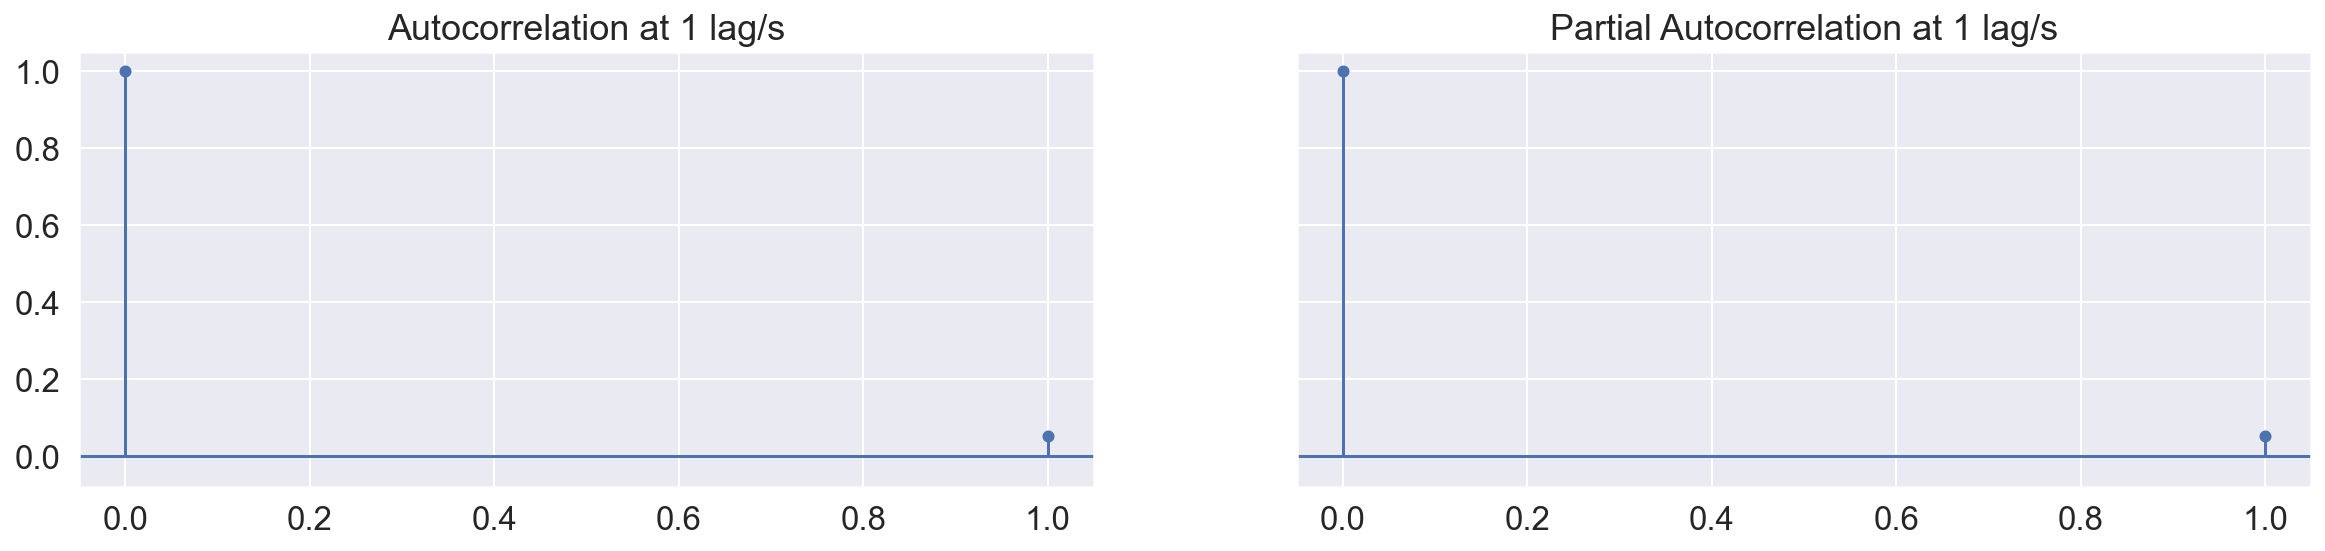

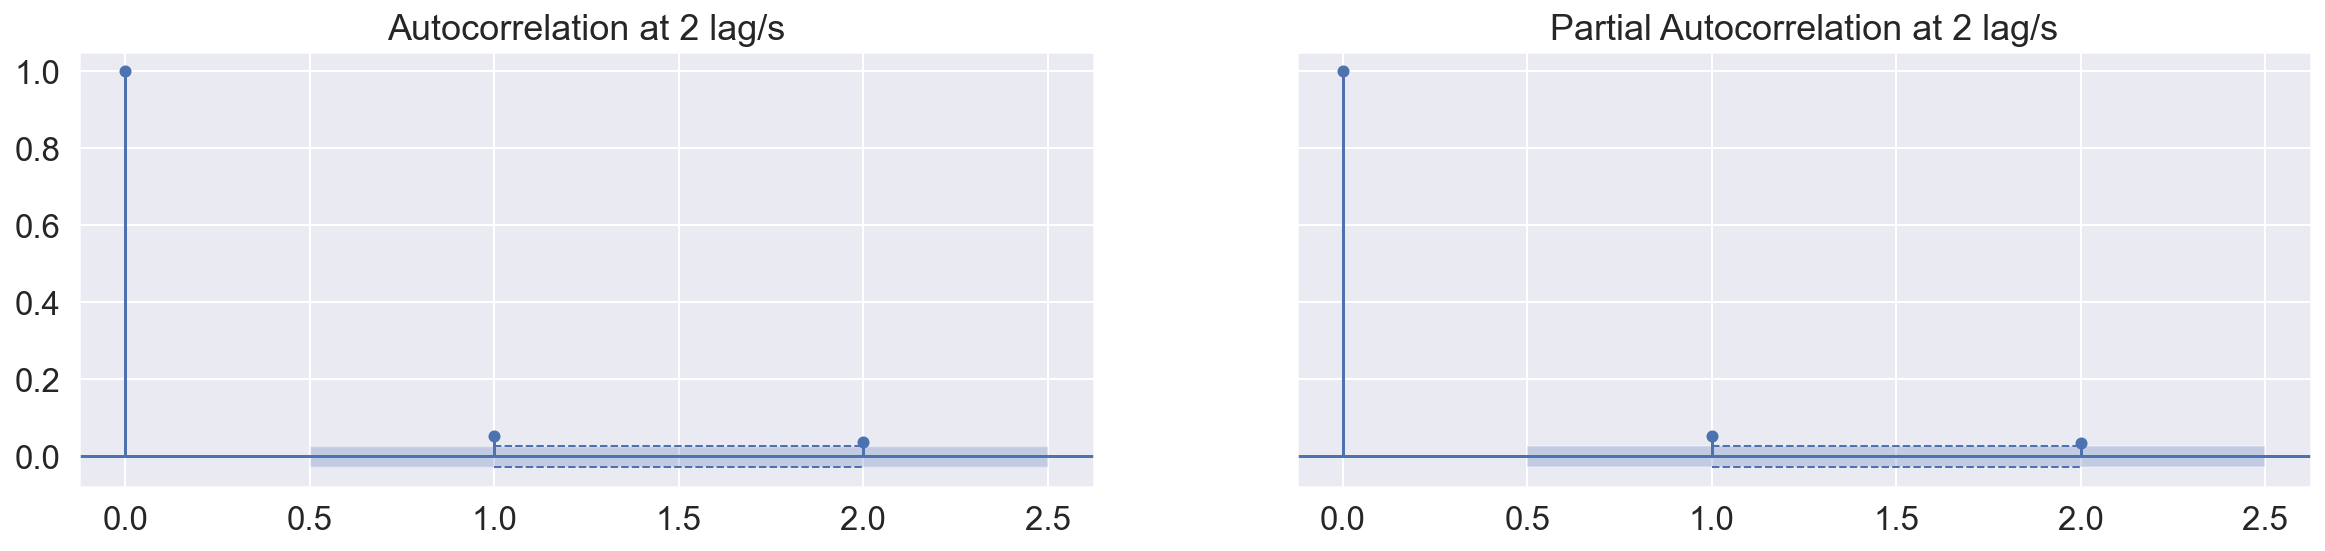

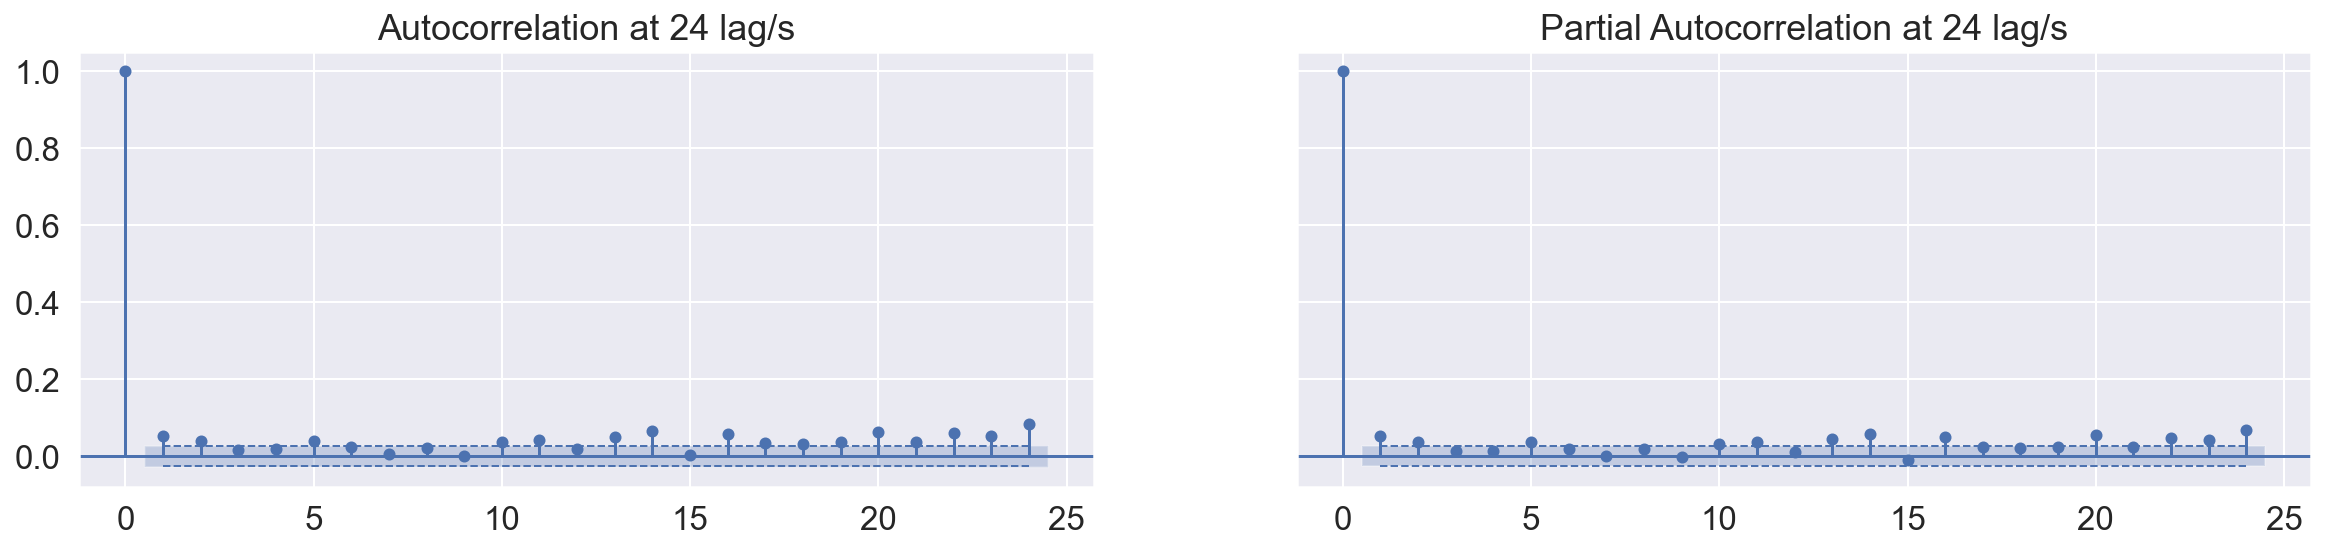

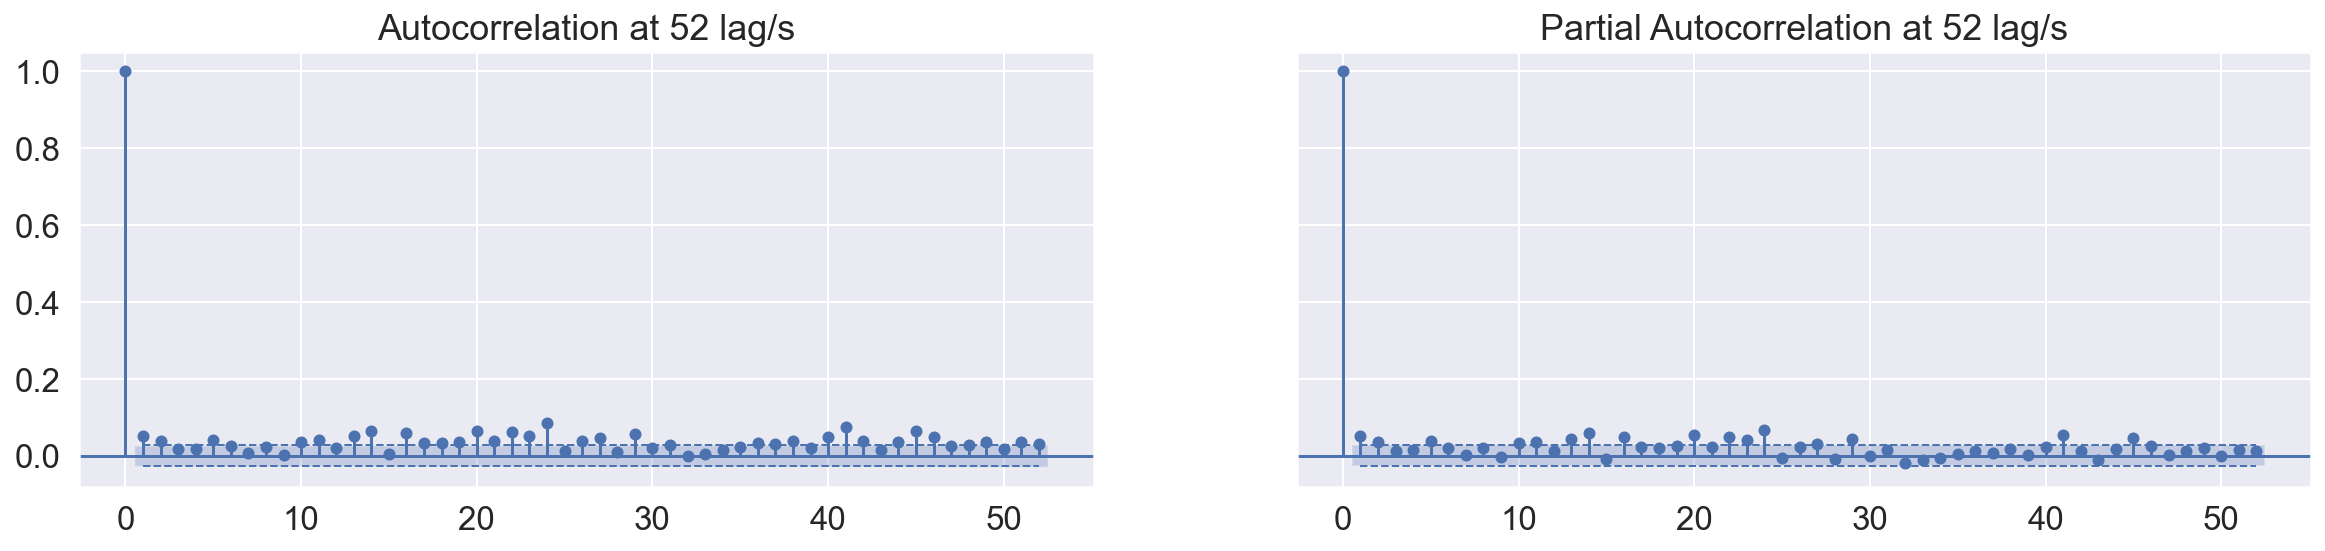

In [54]:
for i in [1, 2, 24, 52]:
    fig, ax = autocorr_plots(awards_by_date['amount_awarded'], lags=i, alpha=0.05, figsize=(20,4))